<a href="https://colab.research.google.com/github/LaZoark/FaultNet/blob/main/%5BFaultNet%5DBearing_classification_JNU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# !wget https://github.com/LaZoark/FaultNet/raw/main/CWRU.zip
# !unzip /content/CWRU.zip
!wget https://github.com/LaZoark/FaultNet/raw/main/Preprocessing/JNU_Preprocessing.rar
!unrar e /content/JNU_Preprocessing.rar


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/JNU_Preprocessing.rar

Extracting  JNU_feature.npy                                                0%  OK 
Extracting  JNU_labels.npy                                                 0%  OK 
Extracting  JNU_dataset.npy                                                1%  2%  3%  4%  5%  6%  7%  8%  9% 10% 11% 12% 13% 14% 15% 16% 17% 18% 19% 20% 21% 22% 23% 24% 25% 26% 27% 28% 29% 30% 31% 32% 33% 34% 35% 36% 37% 38% 39% 40% 41% 42% 43% 44% 45% 46% 47% 48% 49% 50% 51% 52% 53% 54% 55% 56% 57% 58% 59% 60% 61% 62% 63% 64% 65% 66% 67% 68% 69% 70% 71% 72% 73% 74% 75% 76% 77% 78%

In [6]:
import numpy as np
import pandas as pd

In [7]:
import torch
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [218]:
# data = np.load('CWRU_dataset.npy')
# labels = np.load('CWRU_lables.npy')
# data = np.load('/content/CWRU files/signal_data.npy')
# labels = np.load('/content/CWRU files/signal_data_labels.npy')
data = np.load('/content/JNU_dataset.npy')
labels = np.load('/content/JNU_labels.npy', allow_pickle=True)

In [219]:
real_labels = list(set(labels))
real_labels.sort()

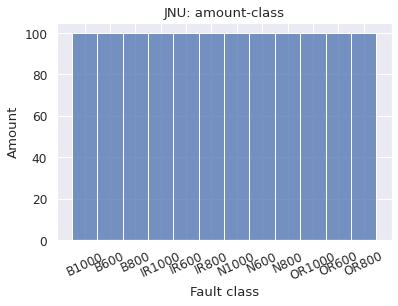

In [220]:
import seaborn as sns
fig, ax = plt.subplots()
fig = sns.histplot(data=labels, kde=False, stat='count', discrete=True, palette='coolwarm', multiple='stack', ax=ax)
# ax.set_xlim(0, 9)
# ax.set_ylim(0, 300)
ax.set_xlabel("Fault class")
ax.set_ylabel("Amount")
# ax.set_title("CWRU: amount-class")
ax.set_title("JNU: amount-class")
for item in fig.get_xticklabels():
    item.set_rotation(25)
plt.show()

In [221]:
print(real_labels)
# Encode the labels
mydict = {}
i = 0
for item in labels:
    if(i>0 and item in mydict):
        continue
    else:    
       i = i+1
       mydict[item] = i-1 # -1 to map '0~11'

k = []
for item in labels:
    k.append(mydict[item])
labels = np.array(k)

['B1000', 'B600', 'B800', 'IR1000', 'IR600', 'IR800', 'N1000', 'N600', 'N800', 'OR1000', 'OR600', 'OR800']


In [222]:
### CWRU
x = data[:, 0:1600]
### JNU
x = data[:, 0:4900]

In [118]:
def mean(data, no_elements):
    X = np.zeros((data.shape[0], data.shape[1]))
    for i in range(data.shape[1] - no_elements + 1):
        X[:, i]=np.mean(data[:, i:i + no_elements], axis=1)
    return X.astype(np.float16)
def median(data, no_elements):
    X = np.zeros((data.shape[0], data.shape[1]))
    for i in range(data.shape[1] - no_elements + 1):
        X[:, i]=np.median(data[:, i:i + no_elements], axis=1)
    return X.astype(np.float16)
def sig_image(data, size):
    X = np.zeros((data.shape[0], size, size))
    for i in range(data.shape[0]):
        X[i]=(data[i, :].reshape(size, size))
    return X.astype(np.float16)

In [119]:
### For CWRU
# _size = 40
# channel_mean = (mean(x, 10)).astype(np.float16)
# x_m = sig_image(channel_mean, 40)
# channel_median = (median(x, 10)).astype(np.float16)
# x_md = sig_image(x, 40)

### For JNU
_size = 70
channel_mean = (mean(x, 10)).astype(np.float16)
x_m = sig_image(channel_mean, _size)
channel_median = (median(x, 10)).astype(np.float16)
x_md = sig_image(x, _size)

In [120]:
x_n = sig_image(x, _size)

In [121]:
x_n.shape

(1200, 70, 70)

In [122]:
x_m.shape

(1200, 70, 70)

In [123]:
X = np.stack((x_n, x_m, x_md), axis=1).astype(np.float16)

In [124]:
X.shape

(1200, 3, 70, 70)

In [125]:
from sklearn.model_selection import train_test_split
trainx, testx, trainlabel, testlabel = train_test_split(X, labels, test_size=0.2, random_state=20)

In [126]:
sig_train, sig_test = trainx, testx
lab_train, lab_test = trainlabel, testlabel

In [127]:
sig_train = torch.from_numpy(sig_train)
sig_test = torch.from_numpy(sig_test)
lab_train = torch.from_numpy(lab_train)
lab_test = torch.from_numpy(lab_test)

In [145]:
import torch.utils.data as data_utils
batch_size = 128
train_tensor = data_utils.TensorDataset(sig_train, lab_train)
train_loader = data_utils.DataLoader(dataset=train_tensor, batch_size=batch_size, shuffle=True)

In [129]:
batch_size = 1024
test_tensor = data_utils.TensorDataset(sig_test, lab_test)
test_loader = data_utils.DataLoader(dataset=test_tensor, batch_size=batch_size, shuffle=False)

In [130]:
sig_train.size()

torch.Size([960, 3, 70, 70])

In [131]:
sig_train.size()[0]

960

In [132]:
sig_test.size()

torch.Size([240, 3, 70, 70])

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class ConvAutoencoder(nn.Module):
    # def __init__(self):
    #     super(ConvAutoencoder, self).__init__()
    #     ## encoder layers ##
    #     # conv layer (depth from 3 --> 32), 4x4 kernels
    #     self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=1, padding=2)  
    #     # conv layer (depth from 32 --> 10), 4x4 kernels
    #     self.conv2 = nn.Conv2d(32, 3, kernel_size=4, stride=1, padding=2)
    #     # pooling layer to reduce x-y dims by two; kernel and stride of 2
    #     self.pool = nn.MaxPool2d(2, 2)
        
    #     ## decoder layers ##
    #     ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
    #     self.t_conv1 = nn.ConvTranspose2d(3, 32, 4, stride=2)
    #     self.t_conv2 = nn.ConvTranspose2d(32, 3, 4, stride=2)
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 1 --> 16), 3x3 kernels
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  
        # conv layer (depth from 16 --> 4), 3x3 kernels
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)

    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # compressed representation
        
        ## decode ##
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        # output layer (with sigmoid for scaling from 0 to 1)
        x = F.sigmoid(self.t_conv2(x))
                
        return x

# initialize the NN
model = ConvAutoencoder().double()
print(model)

ConvAutoencoder(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
)


In [146]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=1, padding=1)
        self.mp1 = nn.MaxPool2d(kernel_size=4, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=1)
        self.mp2 = nn.MaxPool2d(kernel_size=4, stride=2)
        # self.fc1= nn.Linear(2304, 256) # CWRU
        # self.fc1= nn.Linear(sig_train.size()[0]-64, 256)
        self.fc1= nn.Linear(64*14*14, 256)
        self.dp1 = nn.Dropout(p=0.2)
        # self.fc2 = nn.Linear(256, 10) # CWRU
        self.fc2 = nn.Linear(256, 12) # JNU

    def forward(self, x):
        in_size = x.size(0)
        x = F.relu(self.mp1(self.conv1(x)))
        x = F.relu(self.mp2(self.conv2(x)))
        # print(x.shape)
        x = x.view(in_size, -1) # CWRU
        # x = x.view(-1, sig_train.size()[0]-64) # JNU
        x = F.relu(self.fc1(x))
        x = self.dp1(x)
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)

model = CNN().double()
model.cuda()
print(model)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (mp1): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
  (mp2): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=12544, out_features=256, bias=True)
  (dp1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=256, out_features=12, bias=True)
)


In [147]:
criterion = nn.CrossEntropyLoss()

# loss function for AE
# criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [148]:
num_epochs = 100
num_epochs = 50

In [149]:
total_step = len(train_loader)
loss_list = []
acc_list = []
for epoch in range(num_epochs):
    for i, (signals, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        # Run the forward pass
        signals = signals.cuda()
        labels = labels.cuda()
        outputs = model(signals.double())
        loss = criterion(outputs, labels.long())
        # loss = criterion(outputs, signals.double())
        
        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        
        loss.backward()
        optimizer.step()
        # Track the accuracy
        total = labels.size(0)
        # total = signals.size(0)
        _,  predicted = torch.max(outputs.data,  1)
        correct = (predicted == labels.long()).sum().item()
        # correct = (predicted == signals.double()).sum().item()
        acc_list.append(correct / total)

        if (epoch+1) % 5 == 0 or epoch==0:
            print('Epoch [{}/{}],  Step [{}/{}],  Loss: {:.4f},  Train Accuracy: {:.2f}%'
                  .format(epoch + 1,  num_epochs,  i + 1,  total_step,  loss.item(), 
                          (correct / total) * 100))
        

Epoch [1/100],  Step [1/8],  Loss: 2.4934,  Train Accuracy: 9.38%
Epoch [1/100],  Step [2/8],  Loss: 2.6068,  Train Accuracy: 7.03%
Epoch [1/100],  Step [3/8],  Loss: 2.3230,  Train Accuracy: 10.94%
Epoch [1/100],  Step [4/8],  Loss: 2.3963,  Train Accuracy: 8.59%
Epoch [1/100],  Step [5/8],  Loss: 2.3837,  Train Accuracy: 13.28%
Epoch [1/100],  Step [6/8],  Loss: 2.3396,  Train Accuracy: 8.59%
Epoch [1/100],  Step [7/8],  Loss: 2.2948,  Train Accuracy: 6.25%
Epoch [1/100],  Step [8/8],  Loss: 2.2692,  Train Accuracy: 6.25%
Epoch [5/100],  Step [1/8],  Loss: 0.8295,  Train Accuracy: 75.78%
Epoch [5/100],  Step [2/8],  Loss: 0.9700,  Train Accuracy: 65.62%
Epoch [5/100],  Step [3/8],  Loss: 0.7544,  Train Accuracy: 74.22%
Epoch [5/100],  Step [4/8],  Loss: 0.6564,  Train Accuracy: 82.03%
Epoch [5/100],  Step [5/8],  Loss: 0.6694,  Train Accuracy: 78.91%
Epoch [5/100],  Step [6/8],  Loss: 0.6554,  Train Accuracy: 82.81%
Epoch [5/100],  Step [7/8],  Loss: 0.6369,  Train Accuracy: 79.69%
E

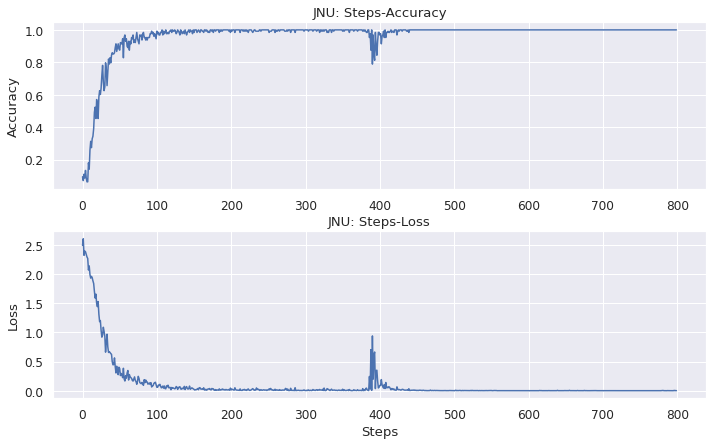

In [151]:
DATASET = 'JNU'
sns.set_theme(style="darkgrid", font_scale=1.1)
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
fig.tight_layout()
sns.lineplot(data=acc_list, ax=ax[0])
# ax.set_xlim(0, 9)
# ax.set_ylim(0, 300)
# ax[0].set_xlabel("Steps")
ax[0].set_ylabel("Accuracy")
ax[0].set_title(f"{DATASET}: Steps-Accuracy")
# plt.show()

# sns.set_theme(style="darkgrid", font_scale=1.1)
# fig, ax = plt.subplots()
sns.lineplot(data=loss_list, ax=ax[1])
ax[1].set_xlabel("Steps")
ax[1].set_ylabel("Loss")
ax[1].set_title(f"{DATASET}: Steps-Loss")
plt.show()

In [156]:
signals.double().shape

torch.Size([240, 3, 70, 70])

In [224]:
total_step = len(test_loader)
print(total_step)
loss_list_test = []
acc_list_test = []
with torch.no_grad():
    for i,  (signals,  labels) in enumerate(test_loader):
        # Run the forward pass
        signals=signals.cuda()
        labels=labels.cuda()
        outputs = model(signals.double())
        loss = criterion(outputs, labels.long())
        loss_list_test.append(loss.item())
        if epoch%10 ==0:
            print(loss)
        total = labels.size(0)
        _,  predicted = torch.max(outputs.data,  1)
        correct = (predicted == labels.long()).sum().item()
        acc_list_test.append(correct / total)
        if (epoch) % 1 == 0:
            print('Epoch [{}/{}],  Step [{}/{}],  Loss: {:.4f},  Accuracy: {:.2f}%'
                  .format(epoch + 1,  num_epochs,  i + 1,  total_step,  loss.item(), 
                          (correct / total) * 100))

1
Epoch [100/100],  Step [1/1],  Loss: 0.5174,  Accuracy: 89.58%


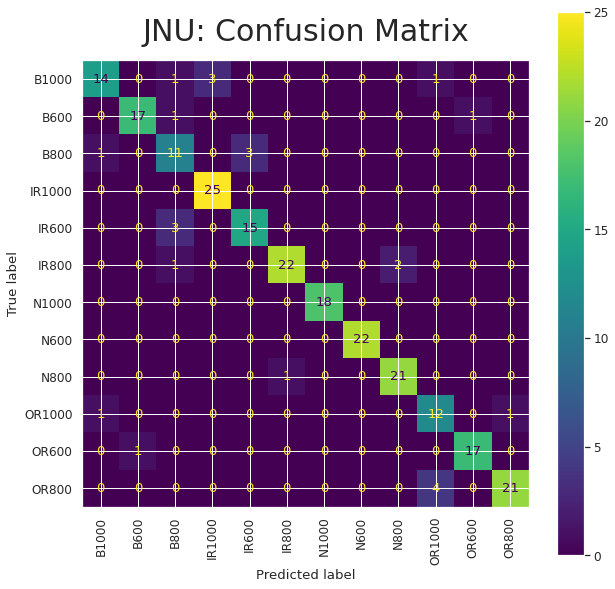

In [245]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(labels.cpu(), predicted.cpu())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=real_labels)
fig, ax = plt.subplots(figsize=(10,10))
plt.title(f'{DATASET}: Confusion Matrix', fontsize=30, pad=20)
disp.plot(xticks_rotation='vertical', ax=ax)

In [246]:
# if you need to save
torch.save(model, f'{DATASET}_{round((correct/total)*100, 3)}.pth')